In [1]:
import torch

import pandas as pd

import sys
sys.path.append('../')

import fl_algorithms as fl
import center_algorithms as ca


import numpy as np


from PSA_utils import *

In [3]:

n_pcs = 3

data = torch.load('../../data/cats_dogs/myCATS.pt').numpy().T
p, n = data.shape


# Hypotheses = [[1,1,1,1,1],
#         [1,1,1,2],[1,1,2,1],[1,2,1,1],[2,1,1,1],
#         [3,1,1],[2,2,1],[1,3,1],[2,1,2],[1,2,2],[1,1,3],
#         [4,1],[3,2],[2,3],[1,4],
#         [5]]

Hypotheses = [[1,1,1],
        [1,2],[2,1],
        [3]]

    # #regular PCA
eigval, eigvec = evd(data)
baseline_weights = eigvec[:,:n_pcs]

In [4]:
def compute_cost(Flag_Collection, Hypotheses):

    # Number of hypotheses
    Nhyp = len(Hypotheses)

    # Initialize cost and NumSubsinFlag arrays
    Cost = np.zeros(Nhyp)
    NumSubsinFlag = np.zeros(Nhyp)

    # Assuming n and Nsamples are defined, and Flag_Collection is a given list of matrices
    n,_ = Flag_Collection[0].shape  # Example value, replace with your actual 'n'
    Nsamples = len(Flag_Collection)  # Example value, replace with your actual 'Nsamples'

    # Loop over hypotheses
    for hh in range(Nhyp):
        dim_subspaces = Hypotheses[hh]
        print(f'testing {np.cumsum(dim_subspaces)}')
        num_subspaces = len(Hypotheses[hh])
        NumSubsinFlag[hh] = num_subspaces
        sum_sig = np.concatenate(([0], np.cumsum(dim_subspaces)))

        # Loop over subspaces in each hypothesis
        for kk in range(num_subspaces):
            Pave = np.zeros((n, n))

            # Accumulate projection matrices
            for nn in range(Nsamples):
                X = Flag_Collection[nn][:, sum_sig[kk]:sum_sig[kk+1]]  # Extract subspace columns
                Pave += X @ X.T  # Accumulate outer products

            # Normalize Pave
            Pave = Pave / Nsamples
            
            # Compute singular values (SVD) of Pave
            eig_signature = np.linalg.svd(Pave, compute_uv=False)
            
            eig_signature1 = eig_signature[:dim_subspaces[kk]]
            eig_signature2 = eig_signature[dim_subspaces[kk]:]
            
            # Update the cost
            Cost[hh] += np.sum(1 - eig_signature1)

    # Weighted Cost: divide cost by number of subspaces in the flag
    Cost = Cost / NumSubsinFlag

    # Plotting the results
    plt.figure()
    plt.semilogy(Cost)
    plt.xlabel('Hypotheses')
    plt.ylabel('Cost')
    plt.show()

    # Find the hypothesis with minimum cost
    a, b = np.min(Cost), np.argmin(Cost)
    print(f"Minimum Cost: {a}, at Hypothesis: {b+1}")


running split 2
testing [1 2 3]
testing [1 3]
testing [2 3]
testing [3]


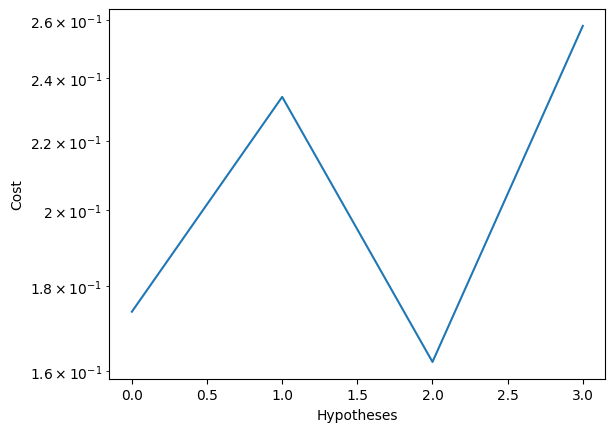

Minimum Cost: 0.16212895337221989, at Hypothesis: 3
running split 3
testing [1 2 3]
testing [1 3]
testing [2 3]
testing [3]


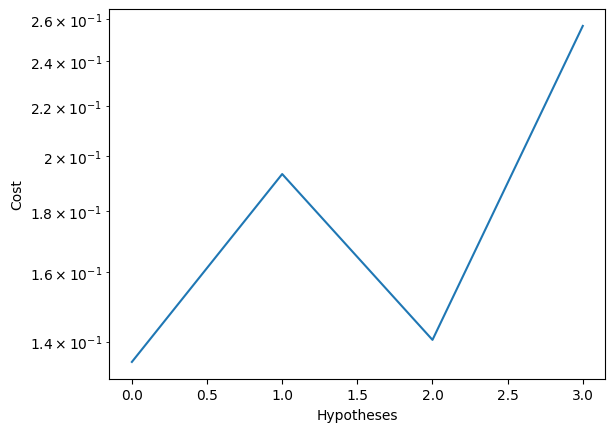

Minimum Cost: 0.13465160953682073, at Hypothesis: 1
running split 4
testing [1 2 3]
testing [1 3]
testing [2 3]
testing [3]


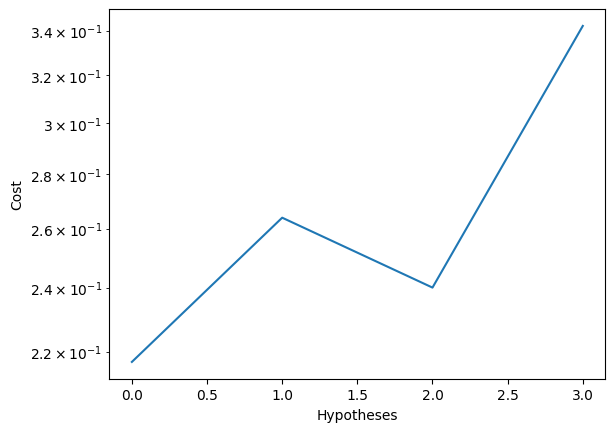

Minimum Cost: 0.21696221521493383, at Hypothesis: 1
running split 5
testing [1 2 3]
testing [1 3]
testing [2 3]
testing [3]


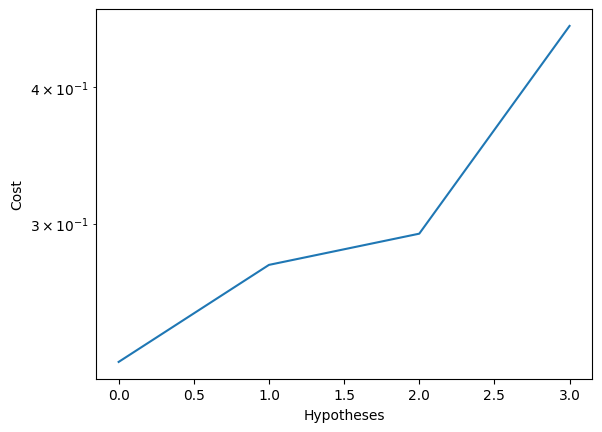

Minimum Cost: 0.22397868867413032, at Hypothesis: 1
running split 6
testing [1 2 3]
testing [1 3]
testing [2 3]
testing [3]


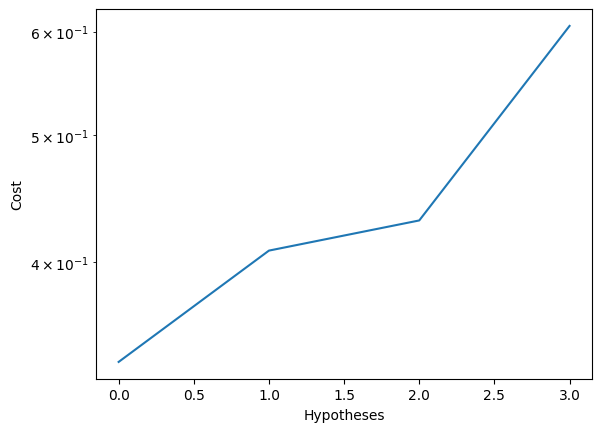

Minimum Cost: 0.3354733434020436, at Hypothesis: 1


In [17]:

n_splits = list(range(2,7,1))
n_trials = 1

for n_split in n_splits:

        print(f'running split {n_split}')
        for trial in range(n_trials):
            np.random.seed(trial)

            weight_data = []
            fl_types = []
            left_over = np.arange(p)
            for split in range(n_split):
                left_over = np.array(list(left_over))
                # subset data
                idx0 = np.random.choice(len(left_over), (p-1)//n_split, replace = False)
                idx = left_over[idx0]
                subset_data = data[idx, :]
                # left over idx
                left_over = set(left_over).difference(set(idx))
            

                # compute pca   
                eigval, eigvec = evd(subset_data)
                weights = eigvec[:,:n_pcs]
                weight_data.append(weights)
            
            compute_cost(weight_data, Hypotheses)


results = pd.DataFrame(columns = ['Number of Splits','Trial', 'Distance', 'Average']) 

            #     fl_type0, bic0 = model_selection_eval(subset_data, eigval, models, criterion="bic")

            #     fl_type = np.cumsum(fl_type0)[:-1]
            #     fl_types.append(list(fl_type))
            
            
            # weight_data_stacked = np.stack(weight_data, axis = 2)

            # # df_avg_weights, mean_f_type = fl.dynamic_flag_mean(weight_data_stacked, fl_types, verbosity=1)

            # mean_f_type = most_common_fl_type(fl_types)

            # #flag average of type mean
            # f_avg_weights = fl.flag_mean(weight_data_stacked, mean_f_type, verbosity = 0)

            # #flag average of type (1,2,3,...,n_pcs)
            # f0_avg_weights = fl.flag_mean(weight_data_stacked, list(np.arange(1,mean_f_type[-1]+1)), verbosity = 0)

            # #flag average of type (n_pcs)
            # #equivalent to gr(n_pcs,n) flag mean
            # g_avg_weights = ca.flag_mean(weight_data, mean_f_type[-1])
            # #g_avg_weights = fl.flag_mean(weight_data_stacked, [3], verbosity = 0)

            # #euclidean average
            # e_avg_weights = np.mean(weight_data_stacked, axis = 2)
            # e_avg_weights = np.linalg.qr(e_avg_weights)[0][:,:mean_f_type[-1]]


            # #distances
            # # df_dist = fl.chordal_dist(df_avg_weights, baseline_weights, true_fl_type)

            # f_dist = fl.chordal_dist(f_avg_weights, baseline_weights, true_fl_type)

            # f0_dist = fl.chordal_dist(f0_avg_weights, baseline_weights, true_fl_type)

            # g_dist = fl.chordal_dist(g_avg_weights, baseline_weights, true_fl_type)

            # e_dist = fl.chordal_dist(e_avg_weights, baseline_weights,true_fl_type)

            # rand_pt = np.random.rand(n,mean_f_type[-1])-.5
            # rand_pt = np.linalg.qr(rand_pt)[0][:,:mean_f_type[-1]]
            # r_dist = fl.chordal_dist(rand_pt, baseline_weights, true_fl_type)


            # trial_results = pd.DataFrame(columns = ['Number of Splits','Trial', 'Distance', 'Average'], 
            #             data = [#[n_split, trial, df_dist, f'dFL-mean{mean_f_type}'],
            #                     [n_split, trial, f0_dist, f'FL-mean{[1,2,3,4,5]}'],
            #                     [n_split, trial, f_dist, f'FL-mean{mean_f_type}'],
            #                     [n_split, trial, g_dist, 'GR-mean'],
            #                     [n_split, trial, e_dist, 'Euclidean-mean'],
            #                     [n_split, trial, r_dist, 'Random']])
            # results = pd.concat([results, trial_results])



            # print(true_fl_type)
            # print(mean_f_type)
            # print()


  

In [5]:
data = torch.load('../../data/cats_dogs/myCATS.pt').numpy().T

p, n = data.shape
mu = np.mean(data, axis=0)
S = 1 / np.sqrt(n) *  (data - mu)

baseline_rec_err = np.sum(np.linalg.norm(S @ baseline_weights @ baseline_weights.T  - S, axis = 1)**2)
 
n_split = 2
n_trials = 20

# fl_types = [[2,3],[1,2,3],[1,2,3],]
fl_type = [2,3]

results = pd.DataFrame(columns = ['Number of Splits','Trial', 'Distance', 'Average']) 

# for fl_type, n_split in zip(fl_types, n_splits):

print(f'running split {n_split}')
for trial in range(n_trials):
    np.random.seed(trial)

    weight_data = []
    fl_types = []
    left_over = np.arange(p)
    for split in range(n_split):
        left_over = np.array(list(left_over))
        # subset data
        idx0 = np.random.choice(len(left_over), (p-1)//n_split, replace = False)
        idx = left_over[idx0]
        subset_data = data[idx, :]
        # left over idx
        left_over = set(left_over).difference(set(idx))
    

        # compute pca   
        eigval, eigvec = evd(subset_data)
        weights = eigvec[:,:n_pcs]
        weight_data.append(weights)

    
    weight_data_stacked = np.stack(weight_data, axis = 2)

    # df_avg_weights, mean_f_type = fl.dynamic_flag_mean(weight_data_stacked, fl_types, verbosity=1)

    # mean_f_type = most_common_fl_type(fl_types)

    #flag average of type mean
    f_avg_weights = fl.flag_mean(weight_data_stacked, fl_type, verbosity = 0)

    #flag average of type (1,2,3,...,n_pcs)
    f0_avg_weights = fl.flag_mean(weight_data_stacked, [1,2,3], verbosity = 0)

    #flag average of type (n_pcs)
    #equivalent to gr(n_pcs,n) flag mean
    g_avg_weights = ca.flag_mean(weight_data, fl_type[-1])
    #g_avg_weights = fl.flag_mean(weight_data_stacked, [3], verbosity = 0)

    #euclidean average
    e_avg_weights = np.mean(weight_data_stacked, axis = 2)
    e_avg_weights = np.linalg.qr(e_avg_weights)[0][:,:fl_type[-1]]


    #distances
    # df_dist = fl.chordal_dist(df_avg_weights, baseline_weights, true_fl_type)

    f_dist = np.sum(np.linalg.norm(S @ f_avg_weights @ f_avg_weights.T  - S, axis = 1)**2)- baseline_rec_err

    f0_dist = np.sum(np.linalg.norm(S @ f0_avg_weights @ f0_avg_weights.T  - S, axis = 1)**2)- baseline_rec_err

    g_dist = np.sum(np.linalg.norm(S @ g_avg_weights @ g_avg_weights.T  - S, axis = 1)**2)- baseline_rec_err

    e_dist = np.sum(np.linalg.norm(S @ e_avg_weights @ e_avg_weights.T  - S, axis = 1)**2)- baseline_rec_err


    trial_results = pd.DataFrame(columns = ['Number of Splits','Trial', 'Distance', 'Average'], 
                data = [#[n_split, trial, df_dist, f'dFL-mean{mean_f_type}'],
                        [n_split, trial, f_dist, f'FL-mean (new)'],
                        [n_split, trial, f0_dist, f'FL-mean (base)'],
                        [n_split, trial, g_dist, 'GR-mean'],
                        [n_split, trial, e_dist, 'Euclidean-mean']])
    print(trial_results)
    results = pd.concat([results, trial_results])

running split 2
   Number of Splits  Trial      Distance         Average
0                 2      0   1506.757599   FL-mean (new)
1                 2      0   2461.243748  FL-mean (base)
2                 2      0   1767.424103         GR-mean
3                 2      0  92489.160341  Euclidean-mean


/var/folders/5m/bv9phk393431tllslwr8yzyw0000gp/T/ipykernel_51947/2149638818.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, trial_results])


   Number of Splits  Trial       Distance         Average
0                 2      1     563.136692   FL-mean (new)
1                 2      1     595.146771  FL-mean (base)
2                 2      1     451.591638         GR-mean
3                 2      1  103754.068140  Euclidean-mean
   Number of Splits  Trial    Distance         Average
0                 2      2  323.519600   FL-mean (new)
1                 2      2  324.610504  FL-mean (base)
2                 2      2  331.423929         GR-mean
3                 2      2  324.599186  Euclidean-mean
   Number of Splits  Trial       Distance         Average
0                 2      3     521.625768   FL-mean (new)
1                 2      3     549.396863  FL-mean (base)
2                 2      3     520.220505         GR-mean
3                 2      3  251432.578783  Euclidean-mean
   Number of Splits  Trial       Distance         Average
0                 2      4     762.580847   FL-mean (new)
1                 2      4   

In [6]:
results.to_csv('./pca_res.csv')

<Axes: xlabel='Number of Splits', ylabel='Distance'>

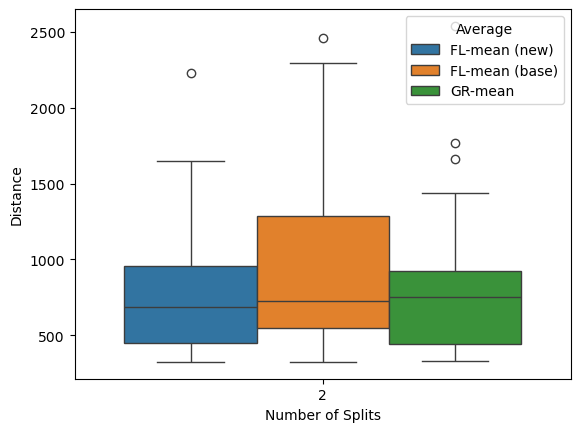

In [4]:
import seaborn as sns

results = pd.read_csv('pca_res.csv', index_col = 0)

results= results[results['Average'] != 'Euclidean-mean']

sns.boxplot(data = results, x = 'Number of Splits', y = 'Distance', hue = 'Average')

In [55]:
flag_type = np.cumsum(Hypotheses[11])

In [56]:
flag_type

array([4, 5])

In [34]:
flag_type = [1,2,3,4,5]

In [36]:
n_pcs

5

In [6]:
n_split = 2
n_trials = 1

print(f'running split {n_split}')
for trial in range(n_trials):
    np.random.seed(trial)

    weight_data = []
    fl_types = []
    left_over = np.arange(p)
    for split in range(n_split):
        left_over = np.array(list(left_over))
        # subset data
        idx0 = np.random.choice(len(left_over), (p-1)//n_split, replace = False)
        idx = left_over[idx0]
        subset_data = data[idx, :]
        # left over idx
        left_over = set(left_over).difference(set(idx))
    

        # compute pca   
        eigval, eigvec = evd(subset_data)
        weights = eigvec[:,:n_pcs]
        weight_data.append(weights)

running split 2


In [7]:
weight_data_stacked = np.stack(weight_data, axis = 2)

In [8]:
f_avg_weights0 = fl.flag_mean(weight_data_stacked, [4,5], verbosity = 0)
f_avg_weights1 = fl.flag_mean(weight_data_stacked, [1,2,3,4,5], verbosity = 0)

In [9]:
n, p = data.shape
mu = np.mean(data, axis=0)
S = 1 / np.sqrt(n) *  (data - mu)

In [10]:
np.sum(np.linalg.norm(S @ f_avg_weights0 @ f_avg_weights0.T  - S, axis = 1)**2)

8113186.364572288

In [11]:
np.sum(np.linalg.norm(S @ f_avg_weights1 @ f_avg_weights1.T  - S, axis = 1)**2)

8159515.447536439

In [12]:
g_avg_weights = ca.flag_mean(weight_data, 5)

In [13]:
f_dist = fl.chordal_dist(f_avg_weights, baseline_weights, flag_type)
g_dist = fl.chordal_dist(g_avg_weights, baseline_weights, flag_type)

NameError: name 'f_avg_weights' is not defined

In [44]:
f_dist, g_dist


(0.6784026901329339, 1.9497785433918633)

In [50]:
np.sum(np.linalg.norm( S @ baseline_weights @ baseline_weights.T  - S, axis = 1)**2)

8013295.492187905

In [51]:
np.sum(np.linalg.norm(S @ f_avg_weights @ f_avg_weights.T  - S, axis = 1)**2)

8159515.447536439

In [52]:
np.sum(np.linalg.norm(S @ g_avg_weights @ g_avg_weights.T  - S, axis = 1)**2)

8086601.6179633895